# Get started!

In [30]:
from pathlib import Path
import polars as pl
from ebrec.utils._constants import *
from ebrec.utils._python import compute_npratio, create_lookup_dict

In [31]:
!pip install matplotlib seaborn
!pip install pyarrow
!pip install pandas
!pip install xlsx2csv

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import matplotlib.ticker as mticker
from matplotlib.ticker import MaxNLocator

## Help functions

In [33]:
EB_COLOR = "#bd1118"


def save_figure(fig, save_path: str = None) -> None:
    if save_path is not None:
        path = Path(save_path)
        path.parent.mkdir(parents=True, exist_ok=True)
        fig.savefig(path, dpi=300)


def plot_histogram(
    df: pl.DataFrame,
    column_name: str = None,
    stat: str = "density",
    save_path: str = None,
    x_max: int = None,
    y_max: int = None,
    binwidth: int = None,
    num_xticks: int = None,
    num_yticks: int = None,
    fontsize: int = 12,
    bins: int = "auto",
) -> None:
    # =>
    fig, ax = plt.subplots(figsize=(18, 14))
    sns.set_theme(style="whitegrid", font_scale=fontsize / 12)
    sns.histplot(
        data=df,
        x=column_name,
        color=EB_COLOR,
        binwidth=binwidth,
        alpha=0.5,
        stat=stat,
        bins=bins,
    )
    if x_max is not None:
        ax.set_xlim([0, x_max])
    if y_max is not None:
        ax.set_ylim([0, y_max])
    ax.yaxis.set_major_formatter(mticker.ScalarFormatter(useMathText=True))
    ax.xaxis.set_major_locator(MaxNLocator(integer=True, nbins=num_xticks))
    if num_yticks is not None:
        ax.yaxis.set_major_locator(MaxNLocator(nbins=num_yticks, prune="lower"))

    plt.grid(axis="x")
    plt.title("")
    plt.xlabel("")
    plt.ylabel(stat.capitalize())
    plt.ticklabel_format(style="sci", axis="y", scilimits=(0, 0))

    save_figure(fig, save_path=save_path)
    plt.show()


def create_bar_plot(
    df: pd.DataFrame,
    x_col: str,
    y_col: str,
    xlabel: str = "",
    ylabel: str = "",
    title: str = None,
    rotation: int = 0,
    fontsize: int = 12,
    colors: list[str] = None,
    y_as_percentage: bool = False,
    y_max: float = None,
    save_path: str = None,
):
    # Set style
    sns.set_theme(style="whitegrid", font_scale=fontsize / 12)
    # Create bar plot
    fig, ax = plt.subplots(figsize=(18, 14))
    ax = sns.barplot(
        data=df,
        x=x_col,
        y=y_col,
        alpha=0.80,
        palette=colors,
        legend=False,
        hue=x_col,
    )
    if y_as_percentage:
        # Format y-axis labels as percentage
        ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f"{x:.0%}"))
    if y_max is not None:
        ax.set_ylim([0, y_max])
    if title:
        plt.title(title)

    # Set labels and title
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.xticks(rotation=rotation)

    # Remove top and right borders
    # sns.despine()
    plt.tight_layout()
    save_figure(fig, save_path=save_path)
    plt.show()


def create_plot(
    x,
    xlabel: str = "",
    ylabel: str = "",
    title: str = None,
    rotation: int = 0,
    marker: str = "",
    linestyle: str = "-",
    fontsize: int = 12,
    markersize: float = 2.0,
    linewidth: float = 2.0,
    color: str = None,
    y_as_percentage: bool = False,
    y_max: float = None,
    x_max: float = None,
    num_xticks: int = None,
    num_yticks: int = None,
    save_path: str = None,
):
    fig, ax = plt.subplots(figsize=(18, 14))
    plt.plot(
        x,
        linewidth=linewidth,
        color=color,
        marker=marker,
        markersize=markersize,
        linestyle=linestyle,
    )
    if y_as_percentage:
        ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f"{x:.0%}"))
    else:
        ax.yaxis.set_major_formatter(mticker.ScalarFormatter(useMathText=True))
    if y_max is not None:
        ax.set_ylim([0, y_max])
    if x_max is not None:
        ax.set_xlim([0, x_max])
    if title:
        ax.set_title(title, fontsize=fontsize)

    ax.xaxis.set_major_locator(MaxNLocator(integer=True, nbins=num_xticks))
    if num_yticks is not None:
        ax.yaxis.set_major_locator(MaxNLocator(nbins=num_yticks, prune="lower"))

    ax.set_xlabel(xlabel, fontsize=fontsize)
    ax.set_ylabel(ylabel, fontsize=fontsize)
    ax.tick_params(axis="x", labelsize=fontsize)
    ax.tick_params(axis="y", labelsize=fontsize)
    plt.xticks(rotation=rotation)
    plt.tight_layout()
    save_figure(fig, save_path=save_path)
    plt.show()


def add_word_count_column(
    df: pl.DataFrame, column: str, column_alias: str
) -> pl.DataFrame:
    return df.with_columns(
        pl.when(pl.col(column) != "")
        .then(pl.col(column).str.split(by=" ").list.len())
        .otherwise(0)
        .alias(column_alias)
    )

----
# Load dataset

In [34]:
PATH = Path("~/ebnerd_data")
TRAIN_VAL_SPLIT = f"ebnerd_full"  # [ebnerd_demo, ebnerd_small, ebnerd_large]
TEST_SPLIT = f"ebnerd_full"

df_behaviors_train = df_behaviors = pl.scan_parquet(
    PATH.joinpath(TRAIN_VAL_SPLIT, "train", "behaviors.parquet")
)
df_history_train = df_behaviors = pl.scan_parquet(
    PATH.joinpath(TRAIN_VAL_SPLIT, "train", "history.parquet")
)
df_behaviors_val = df_behaviors = pl.scan_parquet(
    PATH.joinpath(TRAIN_VAL_SPLIT, "validation", "behaviors.parquet")
)
df_history_val = df_behaviors = pl.scan_parquet(
    PATH.joinpath(TRAIN_VAL_SPLIT, "validation", "history.parquet")
)
df_behaviors_test = df_behaviors = pl.scan_parquet(
    PATH.joinpath(TEST_SPLIT, "test", "behaviors.parquet")
)
df_history_test = df_behaviors = pl.scan_parquet(
    PATH.joinpath(TEST_SPLIT, "test", "history.parquet")
)
df_articles = pl.scan_parquet(PATH.joinpath(TEST_SPLIT, "articles.parquet")).collect()


PLOT_PATH = Path("plot")

## Define some help names

In [35]:
N_INVIEW_ARTICLES = "inview_len"
N_WORDS_TITLE = "title_len"
N_WORDS_SUBTITLE = "subtitle_len"
N_WORDS_BODY = "body_len"
CATEGORY_DIST_NAME = "category_distribution"

## Define helper columns

In [36]:
if DEFAULT_CLICKED_ARTICLES_COL in df_behaviors_test.columns:
    df_behaviors = pl.concat([df_behaviors_train, df_behaviors_val, df_behaviors_test])
else:
    df_behaviors = pl.concat([df_behaviors_train, df_behaviors_val])

df_history = pl.concat([df_history_train, df_history_val, df_history_test])

In [37]:
df_behaviors = df_behaviors.with_columns(
    pl.col(DEFAULT_INVIEW_ARTICLES_COL).list.len().alias(N_INVIEW_ARTICLES)
)
df_articles = (
    df_articles.pipe(add_word_count_column, column="title", column_alias=N_WORDS_TITLE)
    .pipe(add_word_count_column, column="subtitle", column_alias=N_WORDS_SUBTITLE)
    .pipe(add_word_count_column, column="body", column_alias=N_WORDS_BODY)
)

# Dataset overview:

## Behaviors:

In [38]:
n_impressions = df_behaviors.select(DEFAULT_USER_COL).collect().shape[0]
print(f"Selected columns: {df_behaviors.columns}")
print(f"n-impressions: {n_impressions}")
df_behaviors_train.head(5).collect()

Selected columns: ['impression_id', 'article_id', 'impression_time', 'read_time', 'scroll_percentage', 'device_type', 'article_ids_inview', 'article_ids_clicked', 'user_id', 'is_sso_user', 'gender', 'postcode', 'age', 'is_subscriber', 'session_id', 'next_read_time', 'next_scroll_percentage', 'inview_len']
n-impressions: 24630275


impression_id,article_id,impression_time,read_time,scroll_percentage,device_type,article_ids_inview,article_ids_clicked,user_id,is_sso_user,gender,postcode,age,is_subscriber,session_id,next_read_time,next_scroll_percentage
u32,i32,datetime[μs],f32,f32,i8,list[i32],list[i32],u32,bool,i8,i8,i8,bool,u32,f32,f32
47727,null,2023-05-21 21:35:07,20.0,null,1,"[9482380, 9775183, … 9538375]",[9775183],18293,false,null,null,null,false,265,34.0,100.0
47731,null,2023-05-21 21:32:33,13.0,null,1,"[9774557, 9774516, … 9759966]",[9759966],18293,false,null,null,null,false,265,45.0,100.0
47736,null,2023-05-21 21:33:32,17.0,null,1,"[9759966, 9774557, … 9775323]",[9774652],18293,false,null,null,null,false,265,78.0,100.0
47737,null,2023-05-21 21:38:17,27.0,null,1,"[9774580, 9775131, … 9774899]",[9775184],18293,false,null,null,null,false,265,6.0,52.0
47740,null,2023-05-21 21:36:02,48.0,null,1,"[9774826, 9775171, … 9774648]",[9774648],18293,false,null,null,null,false,265,32.0,100.0


## Articles:

In [39]:
print(f"Shape: {df_articles.select(DEFAULT_ARTICLE_ID_COL).shape}")
print(df_articles.columns)
df_articles.head(5)

Shape: (125541, 1)
['article_id', 'title', 'subtitle', 'last_modified_time', 'premium', 'body', 'published_time', 'image_ids', 'article_type', 'url', 'ner_clusters', 'entity_groups', 'topics', 'category', 'subcategory', 'category_str', 'total_inviews', 'total_pageviews', 'total_read_time', 'sentiment_score', 'sentiment_label', 'title_len', 'subtitle_len', 'body_len']


article_id,title,subtitle,last_modified_time,premium,body,published_time,image_ids,article_type,url,ner_clusters,entity_groups,topics,category,subcategory,category_str,total_inviews,total_pageviews,total_read_time,sentiment_score,sentiment_label,title_len,subtitle_len,body_len
i32,str,str,datetime[μs],bool,str,datetime[μs],list[i64],str,str,list[str],list[str],list[str],i16,list[i16],str,i32,i32,f32,f32,str,u32,u32,u32
3000022,"""Hanks beskyldt…","""Tom Hanks har …",2023-06-29 06:20:32,false,"""Tom Hanks skul…",2006-09-20 09:24:18,[3518381],"""article_defaul…","""https://ekstra…","[""David Gardner""]","[""PER""]","[""Kriminalitet"", ""Kendt"", … ""Litteratur""]",414,[432],"""underholdning""",null,null,null,0.9911,"""Negative""",4,16,119
3000063,"""Bostrups aske …","""Studieværten b…",2023-06-29 06:20:32,false,"""Strålende sens…",2006-09-24 07:45:30,"[3170935, 3170939]","""article_defaul…","""https://ekstra…",[],[],"[""Kendt"", ""Underholdning"", … ""Personlig begivenhed""]",118,[133],"""nyheder""",null,null,null,0.5155,"""Neutral""",5,6,388
3000613,"""Jesper Olsen r…","""Den tidligere …",2023-06-29 06:20:33,false,"""Jesper Olsen, …",2006-05-09 11:29:00,[3164998],"""article_defaul…","""https://ekstra…","[""Frankrig"", ""Jesper Olsen"", … ""Jesper Olsen""]","[""LOC"", ""PER"", … ""PER""]","[""Kendt"", ""Sport"", … ""Sygdom og behandling""]",142,"[196, 271]","""sport""",null,null,null,0.9876,"""Negative""",5,16,136
3000700,"""Madonna topløs…","""47-årige Madon…",2023-06-29 06:20:33,false,"""Skal du have s…",2006-05-04 11:03:12,[3172046],"""article_defaul…","""https://ekstra…",[],[],"[""Kendt"", ""Livsstil"", ""Underholdning""]",414,[432],"""underholdning""",null,null,null,0.8786,"""Neutral""",4,26,150
3000840,"""Otto Brandenbu…","""Sangeren og sk…",2023-06-29 06:20:33,false,"""'Og lidt for S…",2007-03-01 18:34:00,[3914446],"""article_defaul…","""https://ekstra…",[],[],"[""Kendt"", ""Underholdning"", … ""Musik og lyd""]",118,[133],"""nyheder""",null,null,null,0.9468,"""Negative""",4,13,142


## More descriptive:

In [40]:
n_pos = (
    pl.concat([df_behaviors_train, df_behaviors_val])
    .select(pl.col(DEFAULT_CLICKED_ARTICLES_COL).list.len())
    .sum()
    .collect()
)[DEFAULT_CLICKED_ARTICLES_COL][0]
n_neg = (
    pl.concat([df_behaviors_train, df_behaviors_val])
    .select(
        pl.col(DEFAULT_INVIEW_ARTICLES_COL).list.len()
        - pl.col(DEFAULT_CLICKED_ARTICLES_COL).list.len()
    )
    .sum()
    .collect()
)[DEFAULT_INVIEW_ARTICLES_COL][0]

n_users = df_behaviors.select(DEFAULT_USER_COL).unique().collect().shape[0]
n_sso_users = (
    df_behaviors.select(pl.col(DEFAULT_IS_SSO_USER_COL))
    .sum()
    .collect()[DEFAULT_IS_SSO_USER_COL][0]
)
n_subscriber_users = (
    df_behaviors.select(pl.col(DEFAULT_IS_SUBSCRIBER_COL))
    .sum()
    .collect()[DEFAULT_IS_SUBSCRIBER_COL][0]
)
n_articles = df_articles.select(DEFAULT_ARTICLE_ID_COL).unique().shape[0]
n_categories = df_articles.select(DEFAULT_CATEGORY_COL).unique().shape[0]
n_subcategories = (
    df_articles.select(pl.col(DEFAULT_SUBCATEGORY_COL).explode()).unique().shape[0]
)
print(f"# Categories: {n_categories}")
print(f"# Subcategories: {n_subcategories}")


def avg_impression_per_user(n_impressions, n_users) -> float:
    return n_impressions / n_users


descriptive_dict = {
    f"# News": n_articles,
    f"# Users": n_users,
    f"# News category": n_categories,
    f"# Impressions": n_impressions,
    f"# News subcategory": n_subcategories,
    f"# Positive": n_pos,
    f"# Negative": n_neg,
    f"NP-ratio": round(compute_npratio(n_pos=n_pos, n_neg=n_neg), 2),
    f"Avg. impression per user": round(
        avg_impression_per_user(n_impressions=n_impressions, n_users=n_users), 2
    ),
    f"Avg. title len. (words)": round(
        df_articles.select(pl.col(N_WORDS_TITLE)).mean()[N_WORDS_TITLE][0], 2
    ),
    f"Avg. abstract len. (words)": round(
        df_articles.select(pl.col(N_WORDS_SUBTITLE)).mean()[N_WORDS_SUBTITLE][0],
        2,
    ),
    f"Avg. body len. (words)": round(
        df_articles.select(pl.col(N_WORDS_BODY)).mean()[N_WORDS_BODY][0],
        2,
    ),
    f"# SSO users": n_sso_users,
    f"# Subscriber users": n_subscriber_users,
}
_ = [print(f"{key}: {value}") for key, value in descriptive_dict.items()]

# Categories: 32
# Subcategories: 263
# News: 125541
# Users: 974791
# News category: 32
# Impressions: 24630275
# News subcategory: 263
# Positive: 24783679
# Negative: 259255831
NP-ratio: 10.46
Avg. impression per user: 25.27
Avg. title len. (words): 6.6
Avg. abstract len. (words): 17.3
Avg. body len. (words): 363.23
# SSO users: 2558143
# Subscriber users: 1634316


-----
# Visualizations:

## Textual features in Articles:

### Title

shape: (9, 2)
┌────────────┬──────────┐
│ statistic  ┆ value    │
│ ---        ┆ ---      │
│ str        ┆ f64      │
╞════════════╪══════════╡
│ count      ┆ 125541.0 │
│ null_count ┆ 0.0      │
│ mean       ┆ 6.601636 │
│ std        ┆ 2.496316 │
│ min        ┆ 0.0      │
│ 25%        ┆ 5.0      │
│ 50%        ┆ 6.0      │
│ 75%        ┆ 8.0      │
│ max        ┆ 27.0     │
└────────────┴──────────┘


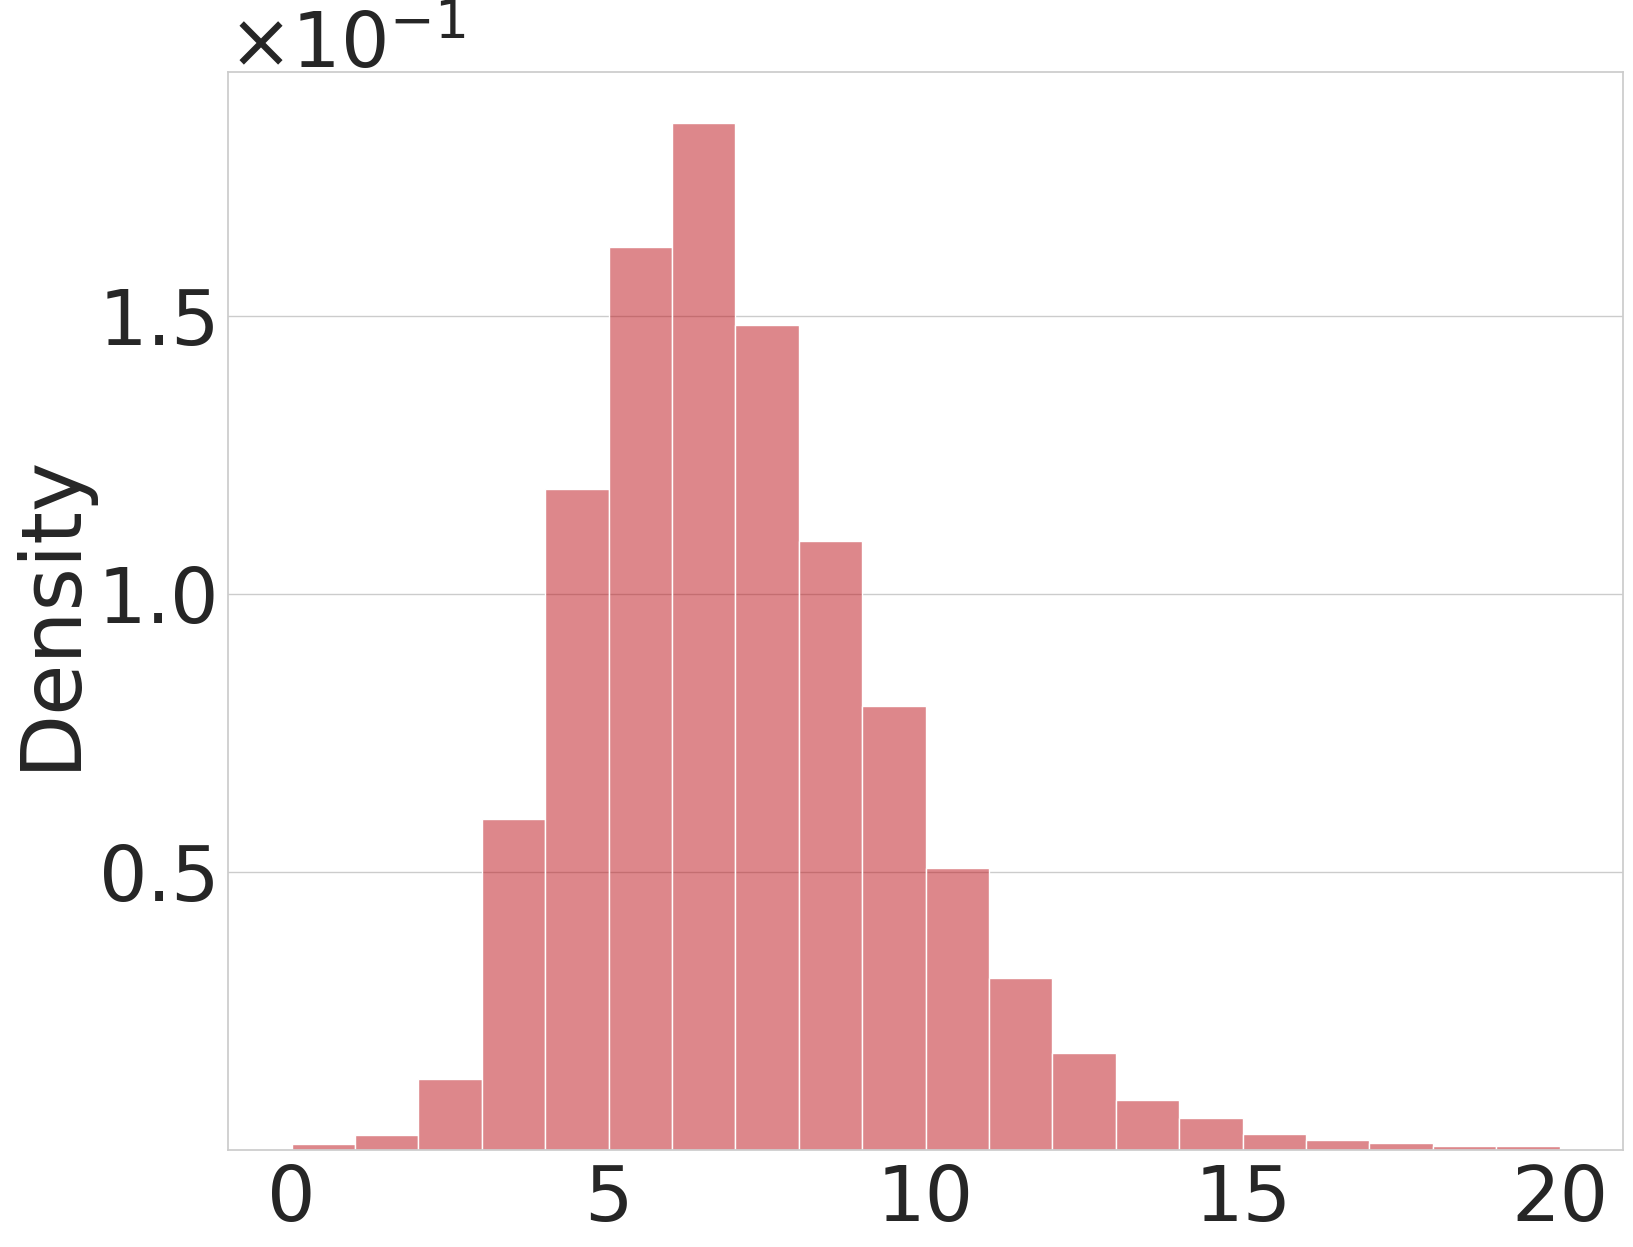

In [60]:
#
print(df_articles[N_WORDS_TITLE].describe())
plot_histogram(
    df_articles.filter(pl.col(N_WORDS_TITLE) <= 20).select(N_WORDS_TITLE),
    num_xticks=5,
    num_yticks=4,
    fontsize=60,
    binwidth=1,
    column_name=N_WORDS_TITLE,
    save_path=PLOT_PATH.joinpath(N_WORDS_TITLE + ".png"),
)

### Subtitle

shape: (9, 2)
┌────────────┬───────────┐
│ statistic  ┆ value     │
│ ---        ┆ ---       │
│ str        ┆ f64       │
╞════════════╪═══════════╡
│ count      ┆ 125541.0  │
│ null_count ┆ 0.0       │
│ mean       ┆ 17.301607 │
│ std        ┆ 8.643949  │
│ min        ┆ 0.0       │
│ 25%        ┆ 13.0      │
│ 50%        ┆ 17.0      │
│ 75%        ┆ 22.0      │
│ max        ┆ 157.0     │
└────────────┴───────────┘


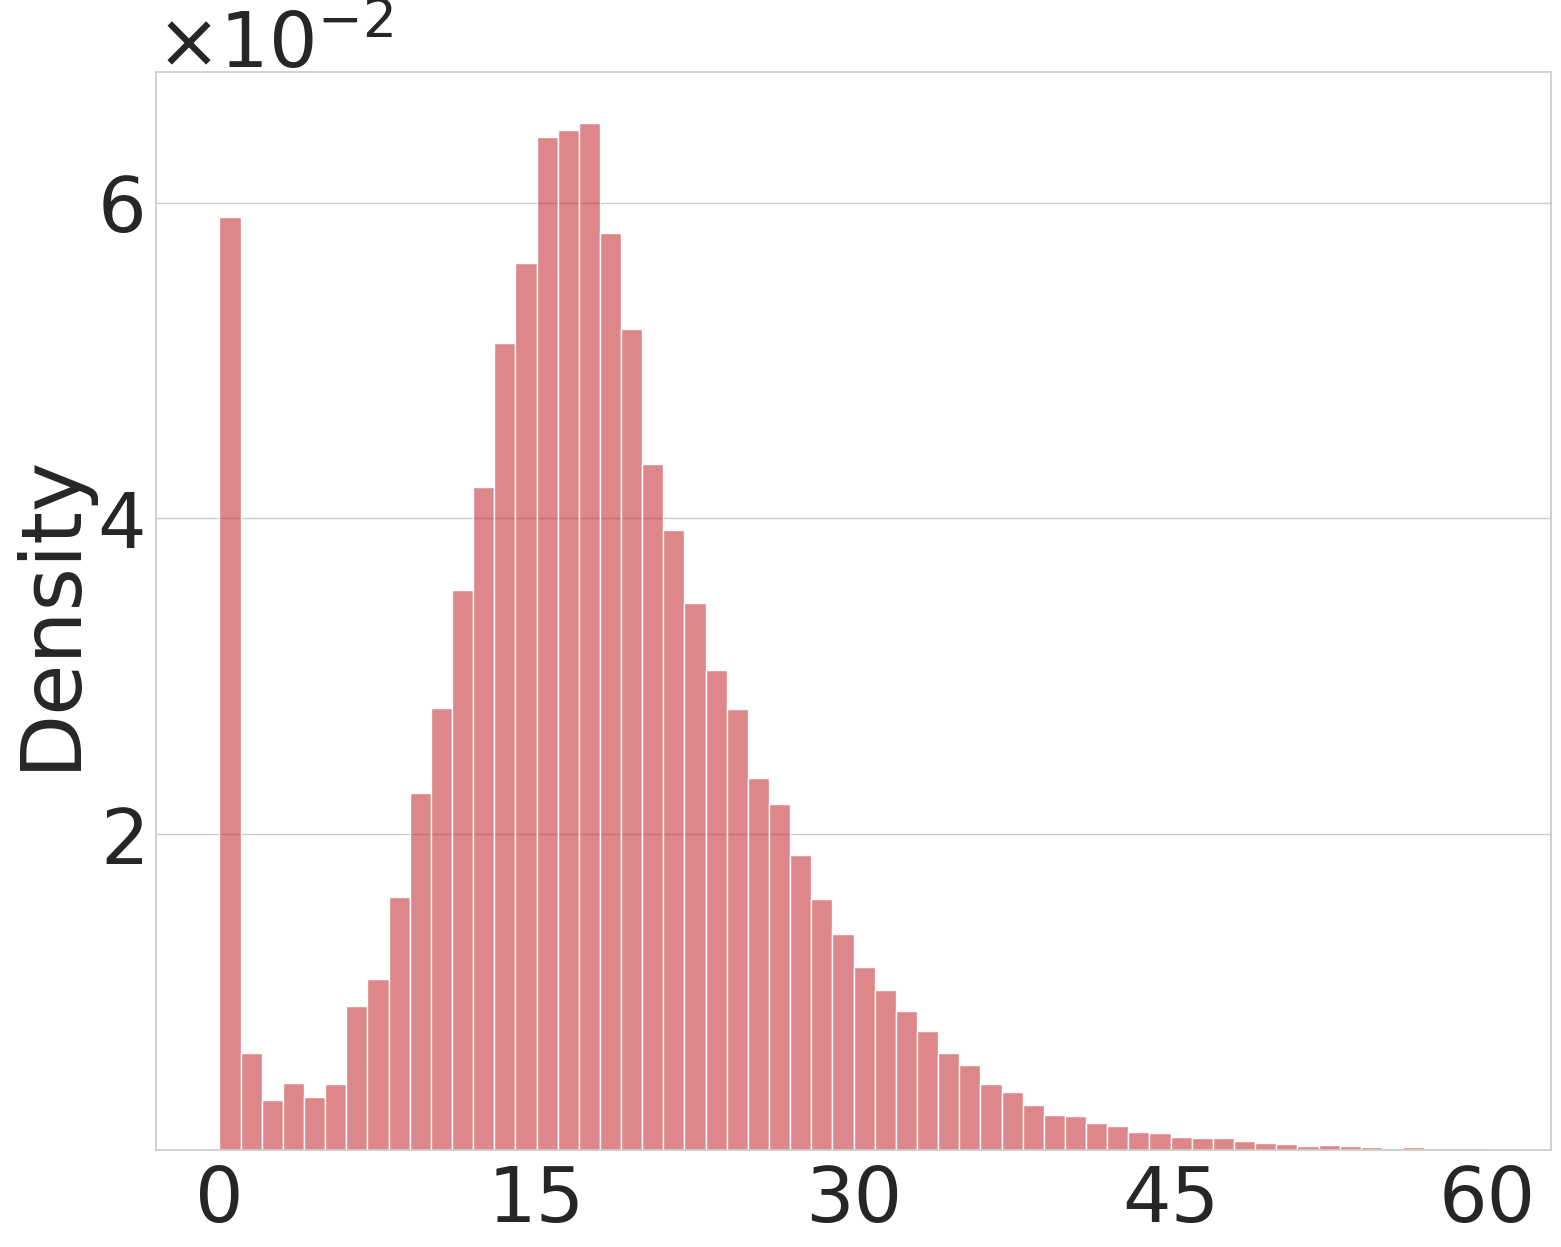

In [61]:
print(df_articles[N_WORDS_SUBTITLE].describe())
plot_histogram(
    df_articles.filter(pl.col(N_WORDS_SUBTITLE) <= 60).select(N_WORDS_SUBTITLE),
    num_xticks=6,
    num_yticks=4,
    fontsize=60,
    binwidth=1,
    column_name=N_WORDS_SUBTITLE,
    save_path=PLOT_PATH.joinpath(N_WORDS_SUBTITLE + ".png"),
)

### Body

shape: (9, 2)
┌────────────┬────────────┐
│ statistic  ┆ value      │
│ ---        ┆ ---        │
│ str        ┆ f64        │
╞════════════╪════════════╡
│ count      ┆ 125541.0   │
│ null_count ┆ 0.0        │
│ mean       ┆ 363.231175 │
│ std        ┆ 306.16982  │
│ min        ┆ 0.0        │
│ 25%        ┆ 195.0      │
│ 50%        ┆ 295.0      │
│ 75%        ┆ 451.0      │
│ max        ┆ 10482.0    │
└────────────┴────────────┘


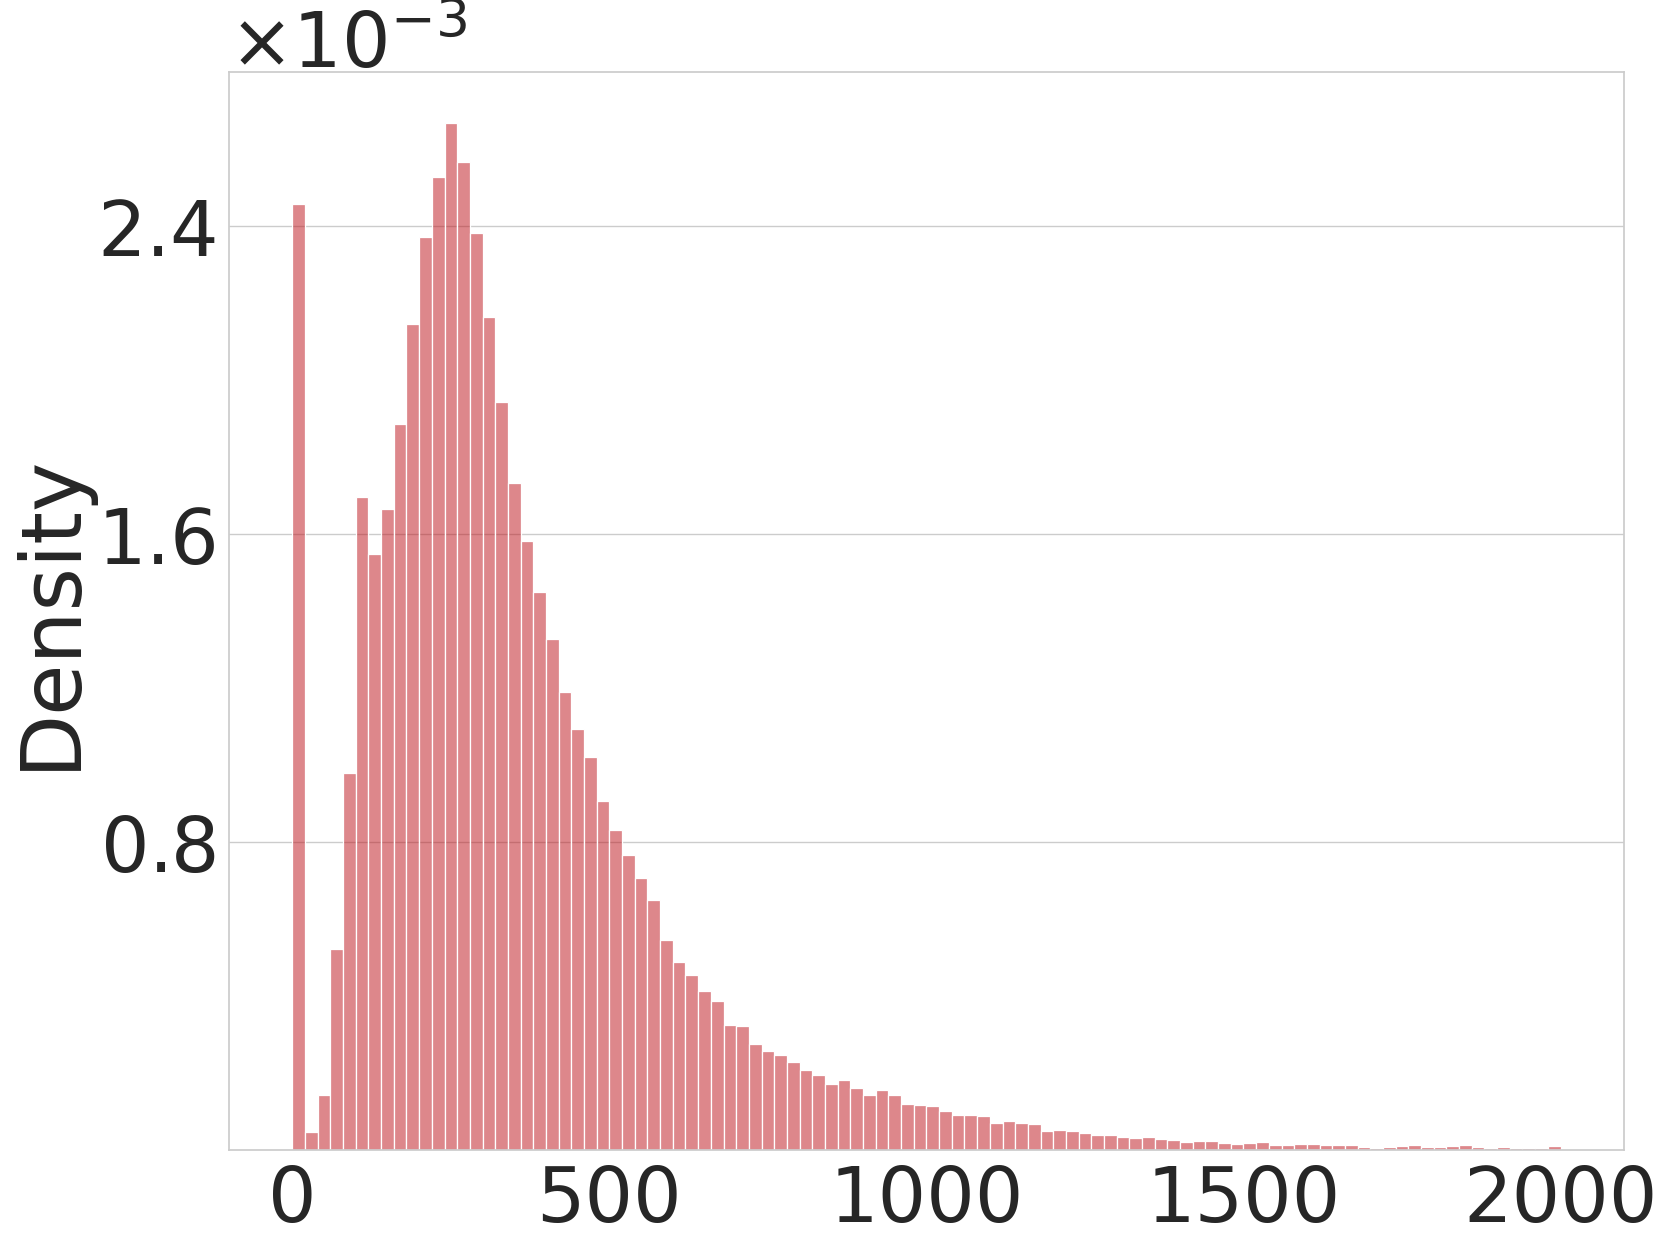

In [62]:
print(df_articles[N_WORDS_BODY].describe())
plot_histogram(
    df_articles.filter(pl.col(N_WORDS_BODY) <= 2_000).select(N_WORDS_BODY),
    num_xticks=5,
    num_yticks=4,
    fontsize=60,
    bins=100,
    binwidth=None,
    column_name=N_WORDS_BODY,
    save_path=PLOT_PATH.joinpath(N_WORDS_BODY + ".png"),
)

## Number of in-view articles per impression

shape: (9, 2)
┌────────────┬─────────────┐
│ statistic  ┆ inview_len  │
│ ---        ┆ ---         │
│ str        ┆ f64         │
╞════════════╪═════════════╡
│ count      ┆ 2.4630275e7 │
│ null_count ┆ 0.0         │
│ mean       ┆ 11.532129   │
│ std        ┆ 8.49619     │
│ min        ┆ 5.0         │
│ 25%        ┆ 6.0         │
│ 50%        ┆ 9.0         │
│ 75%        ┆ 14.0        │
│ max        ┆ 100.0       │
└────────────┴─────────────┘


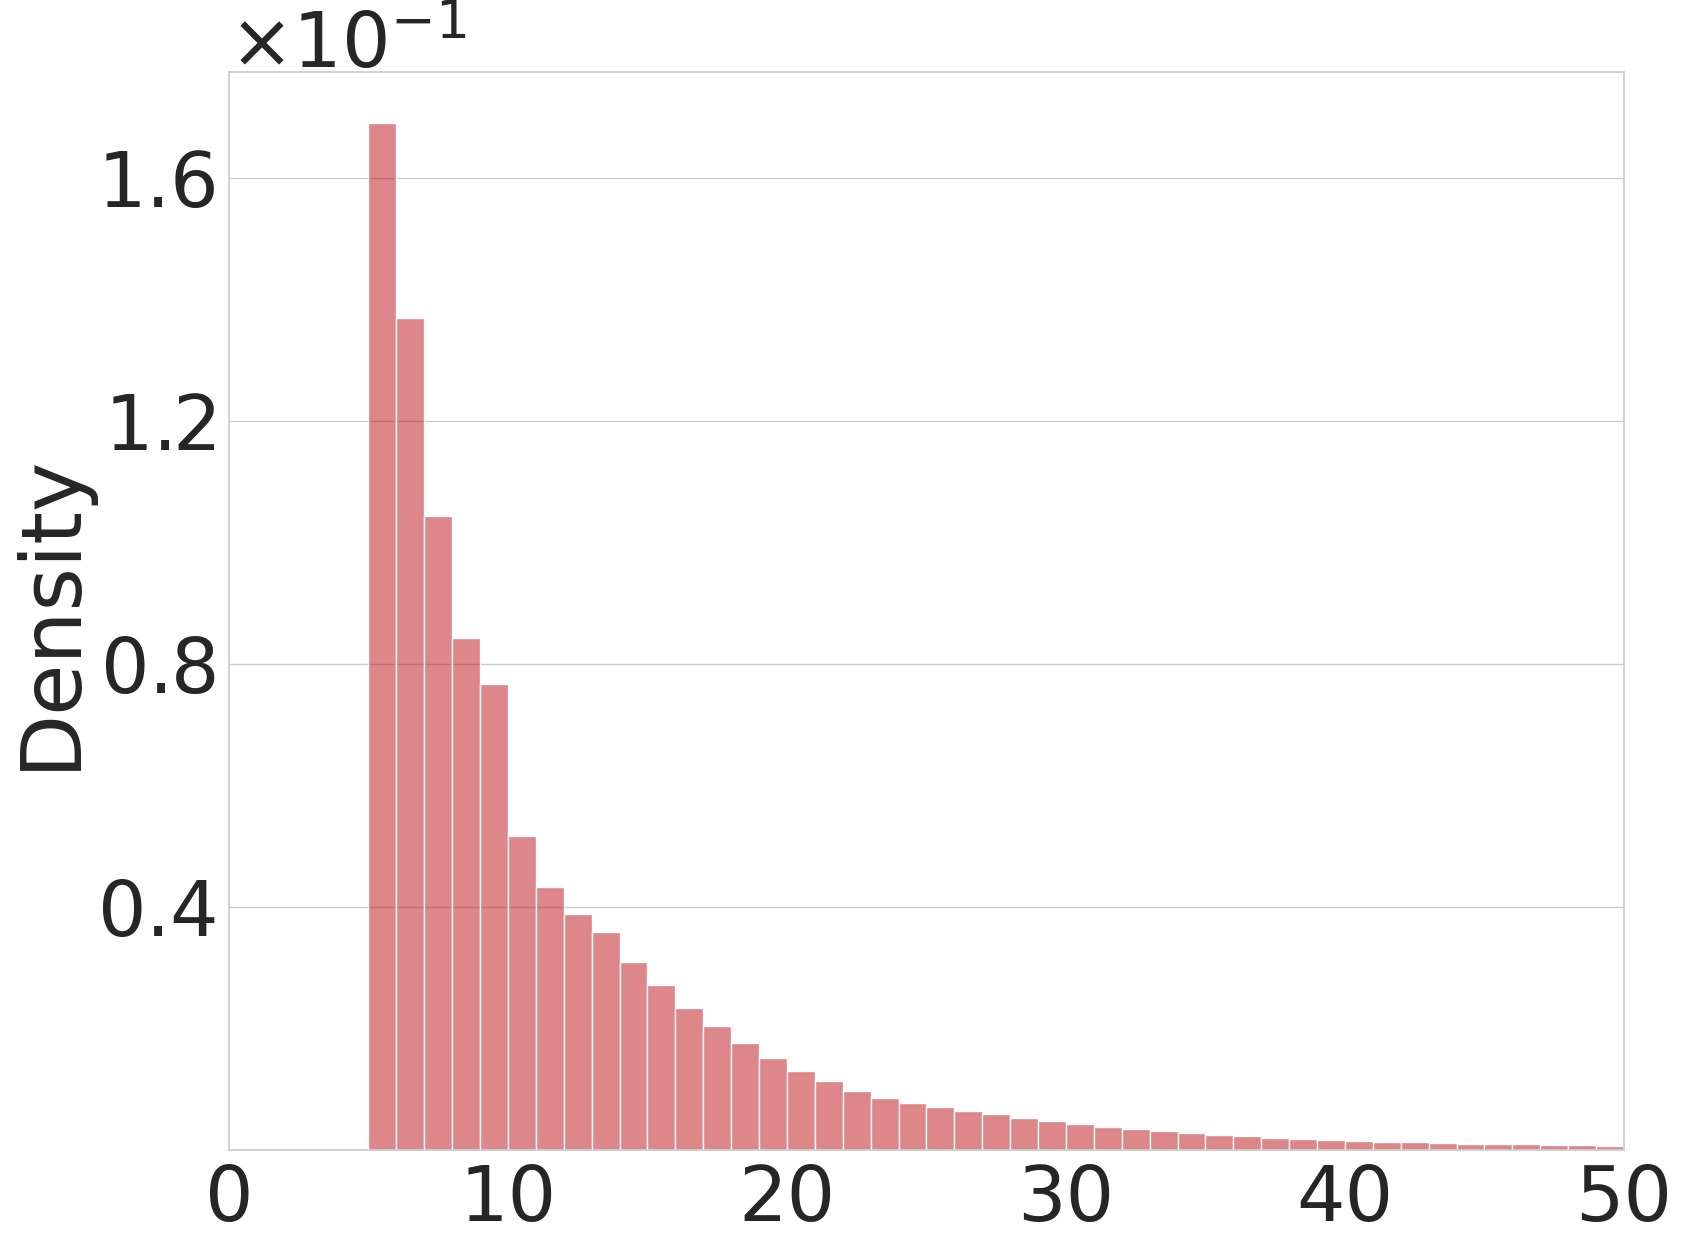

In [63]:
print(df_behaviors.select(N_INVIEW_ARTICLES).describe())
# =>
plot_histogram(
    df_behaviors.select(N_INVIEW_ARTICLES).collect(),
    x_max=50,
    num_xticks=5,
    num_yticks=5,
    fontsize=60,
    binwidth=1,
    column_name=N_INVIEW_ARTICLES,
    save_path=PLOT_PATH.joinpath(N_INVIEW_ARTICLES + f".png"),
)

## Front vs. Article page:

In [64]:
df_frontpage = df_behaviors.filter(pl.col(DEFAULT_ARTICLE_ID_COL).is_null()).collect()
df_articlepage = df_behaviors.filter(
    pl.col(DEFAULT_ARTICLE_ID_COL).is_not_null()
).collect()

### Inviews - front- vs. article page:

/tmp/ipykernel_6855/677349473.py:12: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


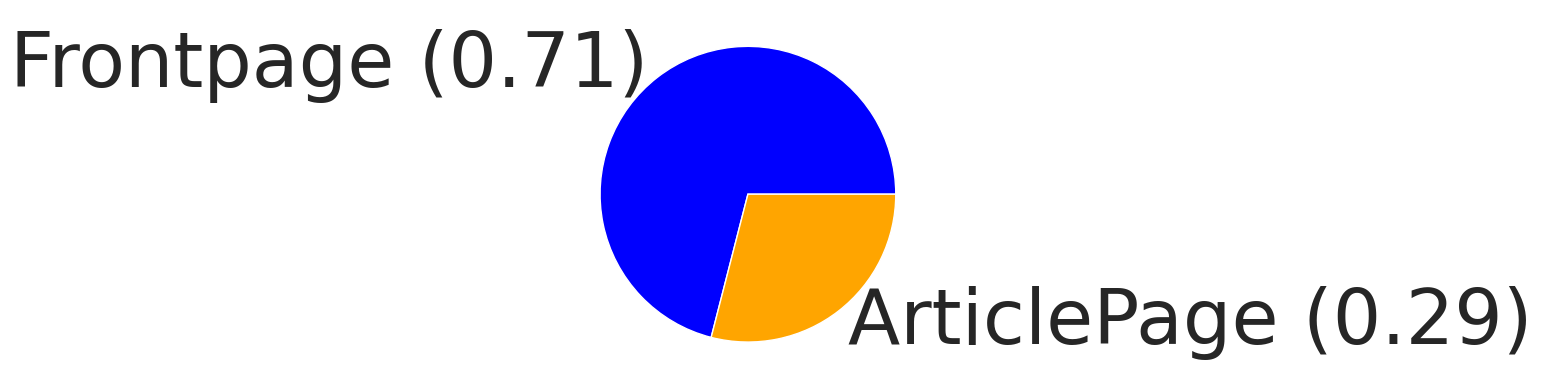

In [65]:
article_page_frac = round(
    df_articlepage.shape[0]
    / df_behaviors.select(DEFAULT_ARTICLE_ID_COL).collect().shape[0],
    2,
)
frontpage_frac = round(1 - article_page_frac, 2)
#
sizes = [frontpage_frac, article_page_frac]
labels = f"Frontpage ({frontpage_frac})", f"ArticlePage ({article_page_frac})"
fig, ax = plt.subplots()
front_article_page = ax.pie(sizes, labels=labels, colors=["blue", "orange"])
plt.tight_layout()
plt.show()
save_figure(fig, save_path=PLOT_PATH.joinpath("front_article_page.png"))

### Readtime - front- vs. article page:

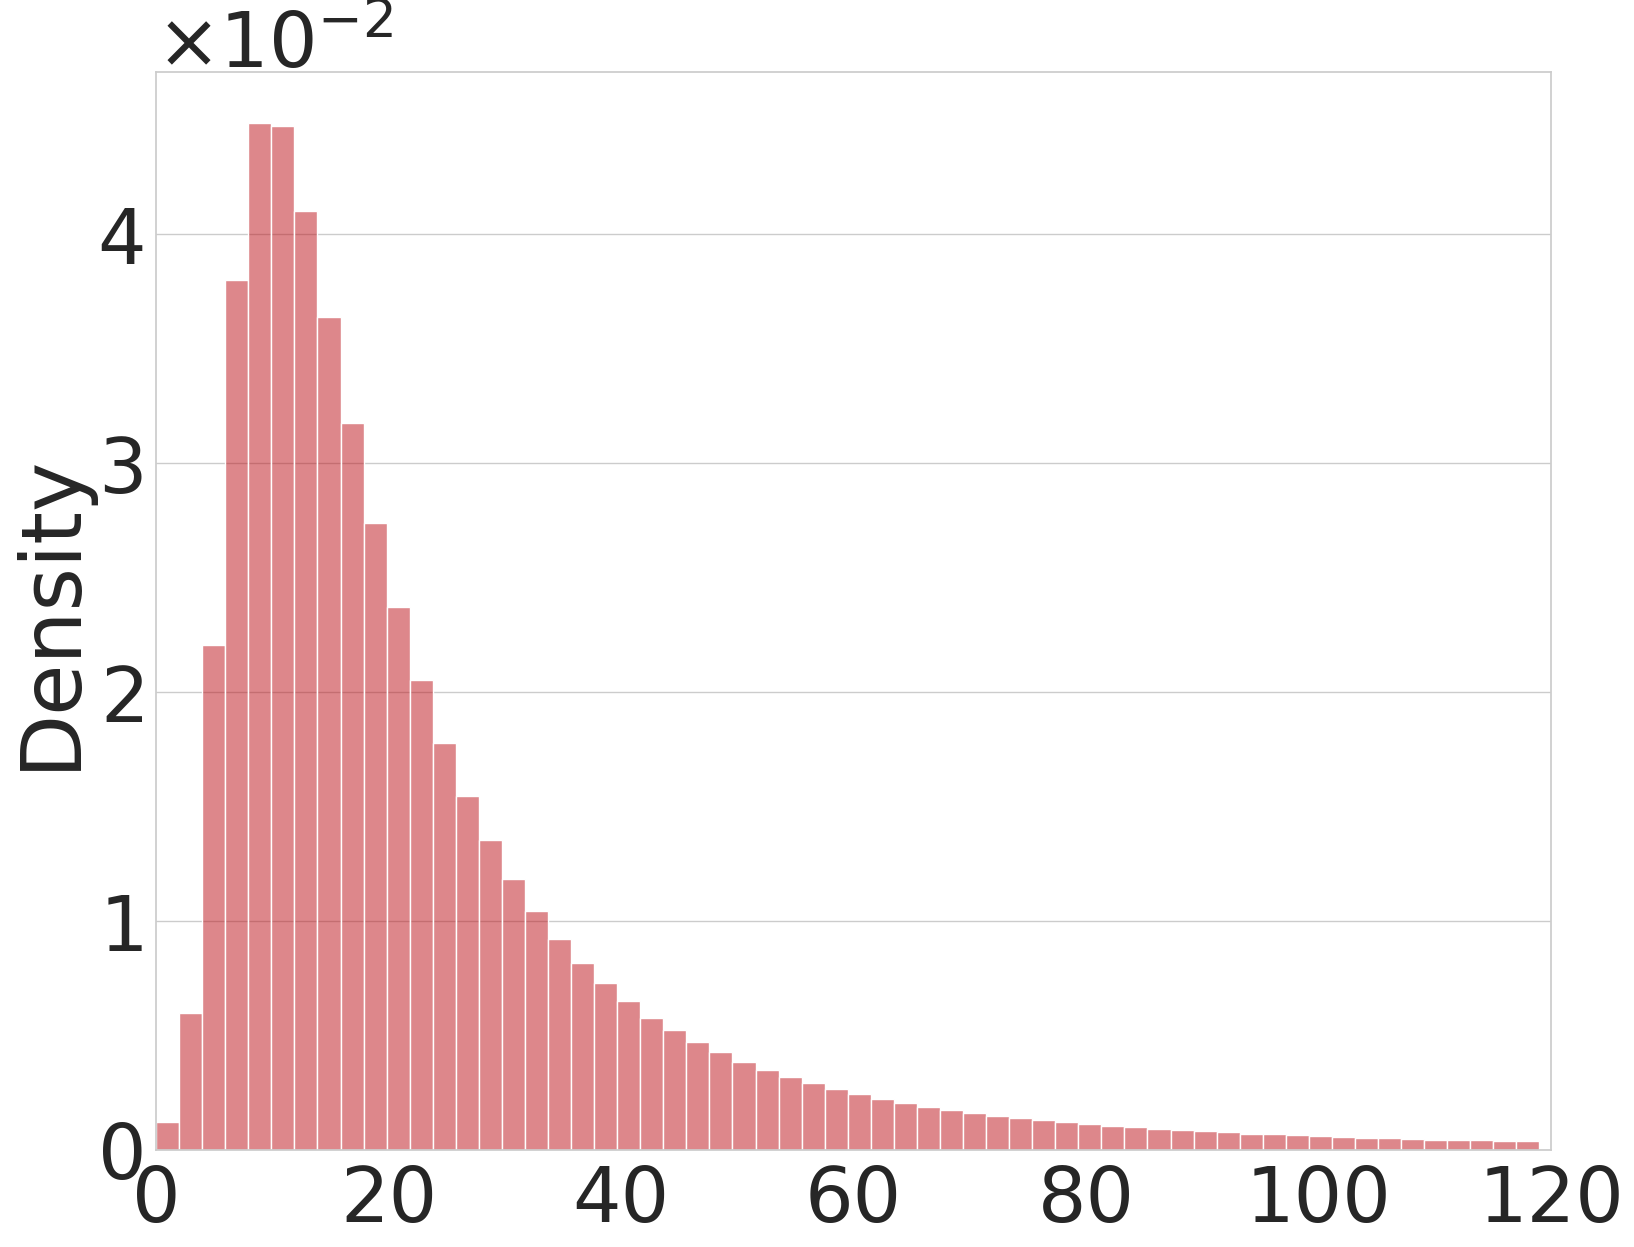

In [66]:
N_SHOW = 120
plot_histogram(
    df_frontpage.filter(pl.col(DEFAULT_READ_TIME_COL) < N_SHOW).select(
        DEFAULT_READ_TIME_COL
    ),
    column_name=DEFAULT_READ_TIME_COL,
    x_max=N_SHOW,
    bins=60,
    num_xticks=6,
    fontsize=60,
    save_path=PLOT_PATH.joinpath("front_read_time.png"),
)

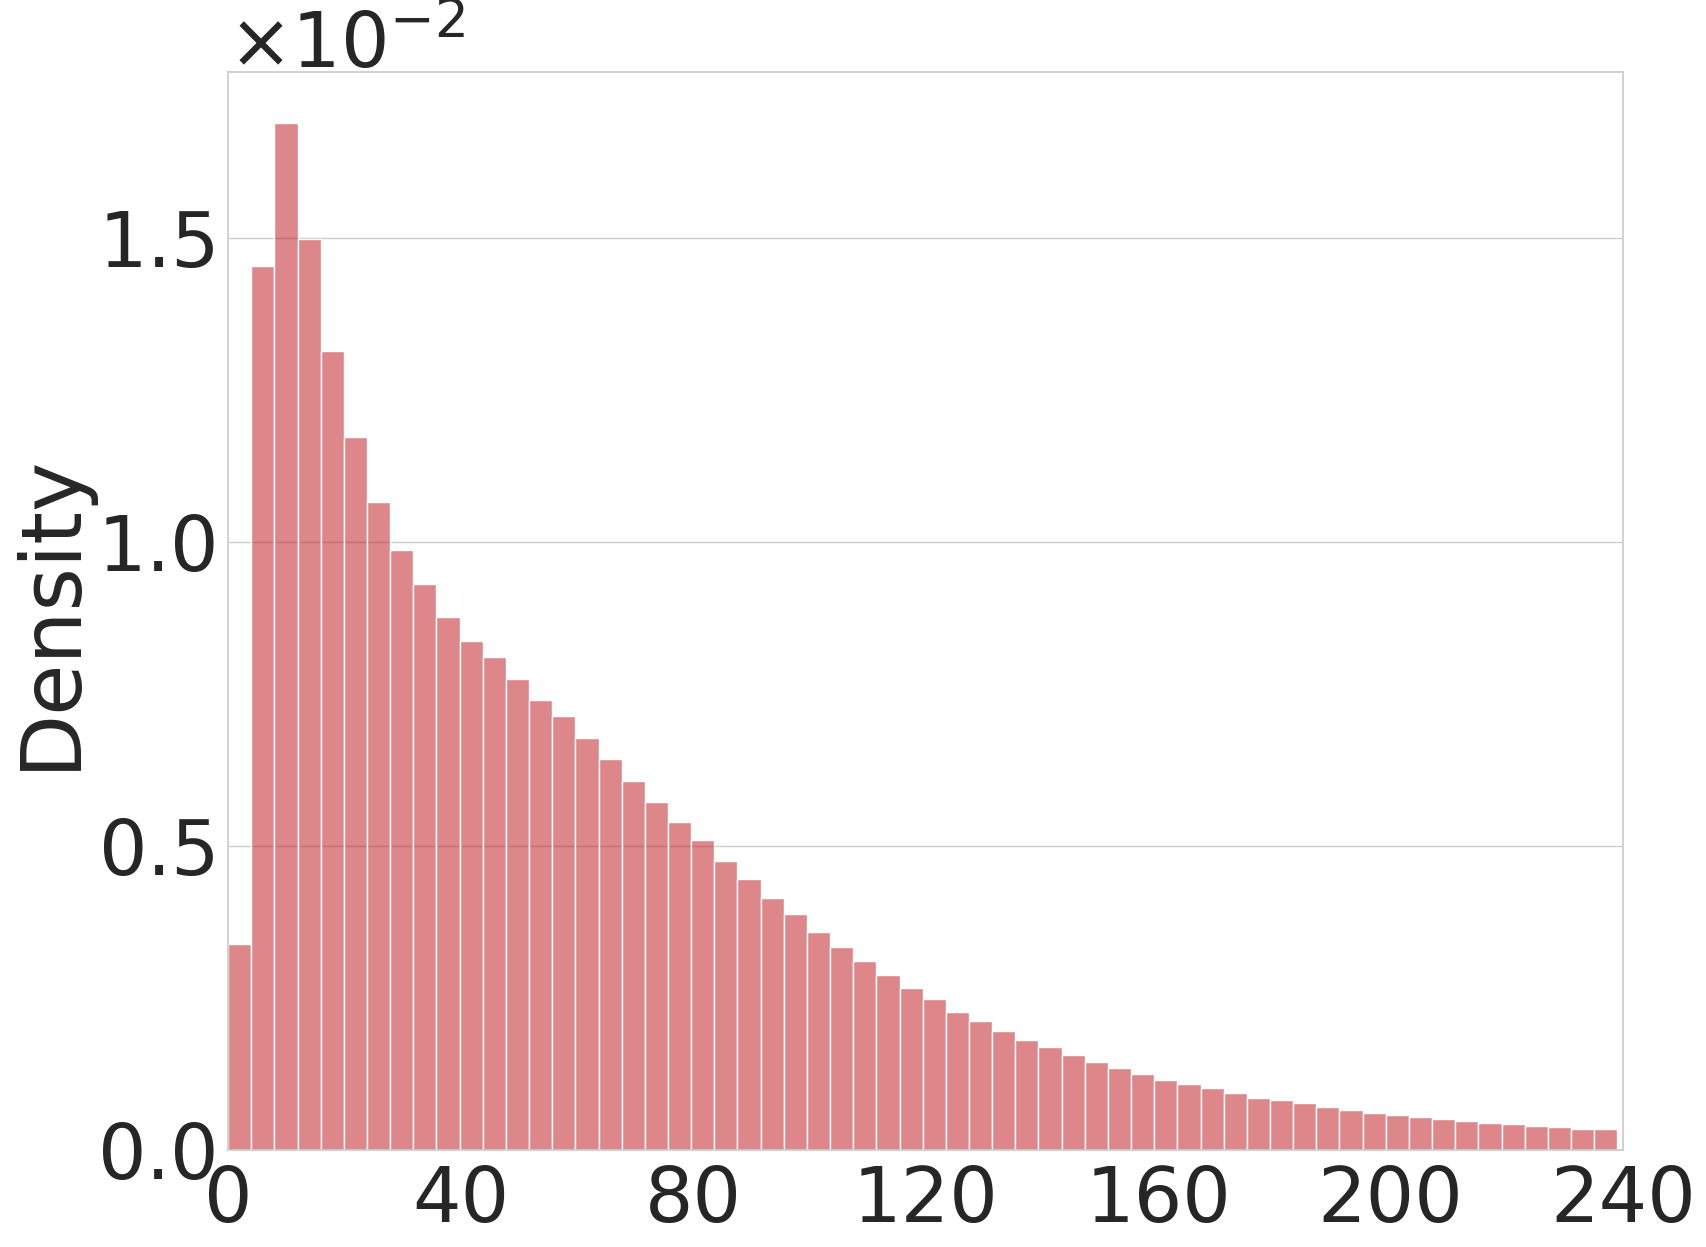

In [67]:
N_SHOW = 240
plot_histogram(
    df_articlepage.filter(pl.col(DEFAULT_READ_TIME_COL) < N_SHOW).select(
        DEFAULT_READ_TIME_COL
    ),
    column_name=DEFAULT_READ_TIME_COL,
    x_max=N_SHOW,
    bins=60,
    num_xticks=6,
    fontsize=60,
    save_path=PLOT_PATH.joinpath("article_read_time.png"),
)

## Article category distributions:

In [68]:
df_articles[DEFAULT_CATEGORY_STR_COL].value_counts(sort=True).head(15)

category_str,count
str,u32
"""nyheder""",27876
"""underholdning""",24909
"""krimi""",22579
"""sport""",18767
"""side9""",4628
"""forbrug""",4328
"""sex_og_samliv""",4030
"""musik""",3641
"""auto""",3513


In [69]:
translate = {
    "nyheder": "News",
    #
    "underholdning": "Entmt.",
    "musik": "Entmt.",
    #
    "krimi": "Crime",
    #
    "sport": "Sports",
    #
    "forbrug": "Lifestyle",
    "biler": "Lifestyle",
    "ferie": "Lifestyle",
    "vin": "Lifestyle",
    #
    "sex_og_samliv": "S&R",
    #
    "nationen": "Opinion",
    "opinionen": "Opinion",
}

df_category = (
    df_articles[DEFAULT_CATEGORY_STR_COL]
    .replace(translate, default="Misc.")
    .value_counts(sort=True)
    .with_columns(pl.col("count") / pl.col("count").sum())
)

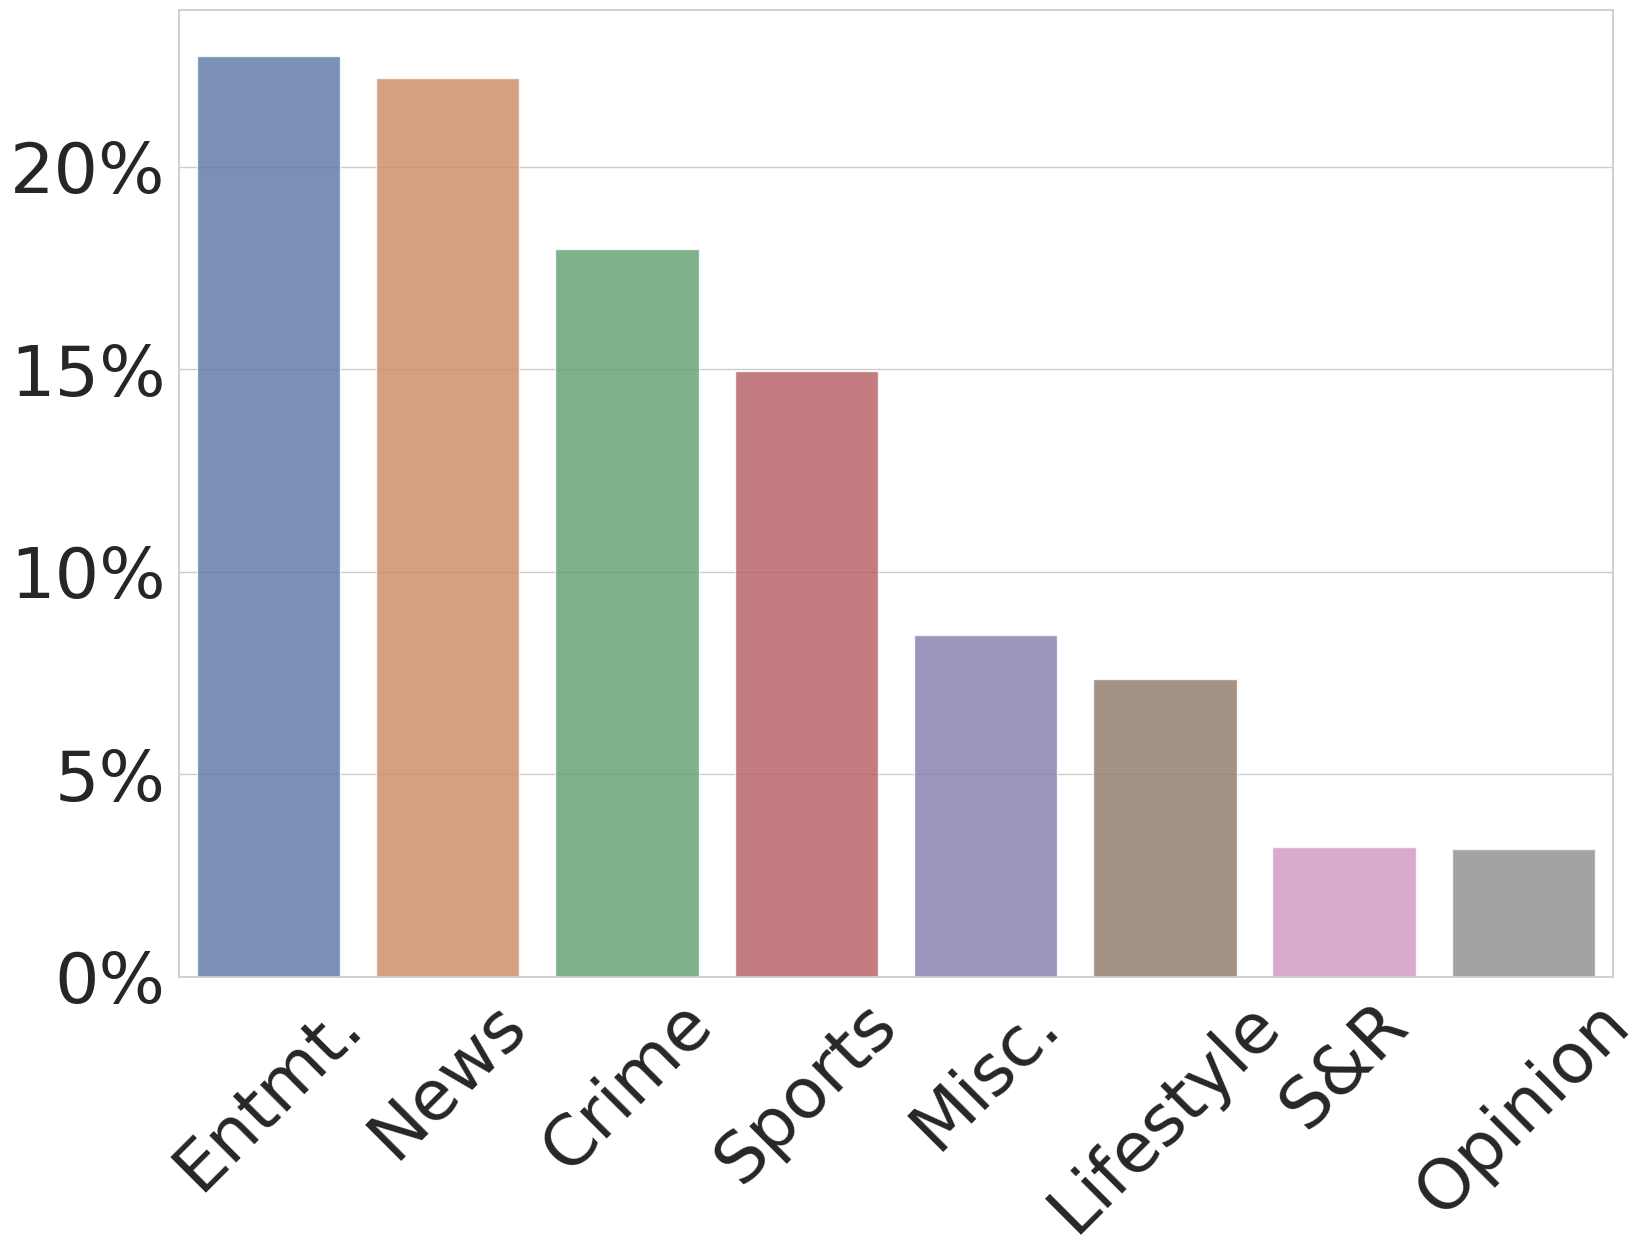

In [70]:
create_bar_plot(
    df_category.to_pandas(),
    x_col=DEFAULT_CATEGORY_STR_COL,
    y_col="count",
    y_as_percentage=True,
    colors=sns.color_palette(n_colors=df_category.shape[0]),
    fontsize=55,
    rotation=45,
    save_path=PLOT_PATH.joinpath(CATEGORY_DIST_NAME + ".png"),
)

-----
# Survival time:
We define "survival-time" as the interval between its publish time and last appearance time in behavioral dataset.

In [100]:
df_articles_in_period = df_articles.select(
    pl.col(DEFAULT_ARTICLE_ID_COL, DEFAULT_ARTICLE_PUBLISHED_TIMESTAMP_COL)
)

TIME_COLUMN = "survival_time"

df_survival_time = (
    df_behaviors.select(DEFAULT_ARTICLE_ID_COL, DEFAULT_IMPRESSION_TIMESTAMP_COL)
    .group_by(DEFAULT_ARTICLE_ID_COL)
    .agg(pl.col(DEFAULT_IMPRESSION_TIMESTAMP_COL).max())
    .collect()
    .join(
        df_articles.select(
            DEFAULT_ARTICLE_ID_COL, DEFAULT_ARTICLE_PUBLISHED_TIMESTAMP_COL
        ),
        on=DEFAULT_ARTICLE_ID_COL,
        how="inner",
    )
    # .filter(
    #     pl.col(DEFAULT_IMPRESSION_TIMESTAMP_COL).min()
    #     < pl.col(DEFAULT_ARTICLE_PUBLISHED_TIMESTAMP_COL)
    # )
    .with_columns(
        (
            pl.col(DEFAULT_IMPRESSION_TIMESTAMP_COL)
            - pl.col(DEFAULT_ARTICLE_PUBLISHED_TIMESTAMP_COL)
        ).alias(TIME_COLUMN)
    )
)
df_survival_time.head(2)

article_id,impression_time,published_time,survival_time
i32,datetime[μs],datetime[μs],duration[μs]
3000613,2023-05-31 02:40:11,2006-05-09 11:29:00,6230d 15h 11m 11s
3006206,2023-05-27 20:52:25,2007-03-06 08:21:37,5926d 12h 30m 48s


### Convert to survival-time to hours:

In [101]:
ONE_HOUR = 60 * 60
SURVIVAL_TIME_ROUND = TIME_COLUMN + "_hours"
df_survival_time = df_survival_time.with_columns(
    pl.col(TIME_COLUMN)
    .map_elements(lambda x: x.total_seconds() // ONE_HOUR)
    .alias(SURVIVAL_TIME_ROUND)
)
print(df_survival_time.select(SURVIVAL_TIME_ROUND).describe())
df_survival_time.head(2)

shape: (9, 2)
┌────────────┬─────────────────────┐
│ statistic  ┆ survival_time_hours │
│ ---        ┆ ---                 │
│ str        ┆ f64                 │
╞════════════╪═════════════════════╡
│ count      ┆ 10326.0             │
│ null_count ┆ 0.0                 │
│ mean       ┆ 21722.490122        │
│ std        ┆ 38915.51413         │
│ min        ┆ 0.0                 │
│ 25%        ┆ 584.0               │
│ 50%        ┆ 3706.0              │
│ 75%        ┆ 21532.0             │
│ max        ┆ 202712.0            │
└────────────┴─────────────────────┘


article_id,impression_time,published_time,survival_time,survival_time_hours
i32,datetime[μs],datetime[μs],duration[μs],f64
3000613,2023-05-31 02:40:11,2006-05-09 11:29:00,6230d 15h 11m 11s,149535.0
3006206,2023-05-27 20:52:25,2007-03-06 08:21:37,5926d 12h 30m 48s,142236.0


### Plot survival time

In [102]:
N_HOURS = 72
frac_impresion_covered = (
    df_survival_time.filter(pl.col(SURVIVAL_TIME_ROUND) < N_HOURS).shape[0]
    / df_survival_time.shape[0]
)
print(f"Fraction of impressions covered: {round(frac_impresion_covered,3)*100}%")

Fraction of impressions covered: 5.5%


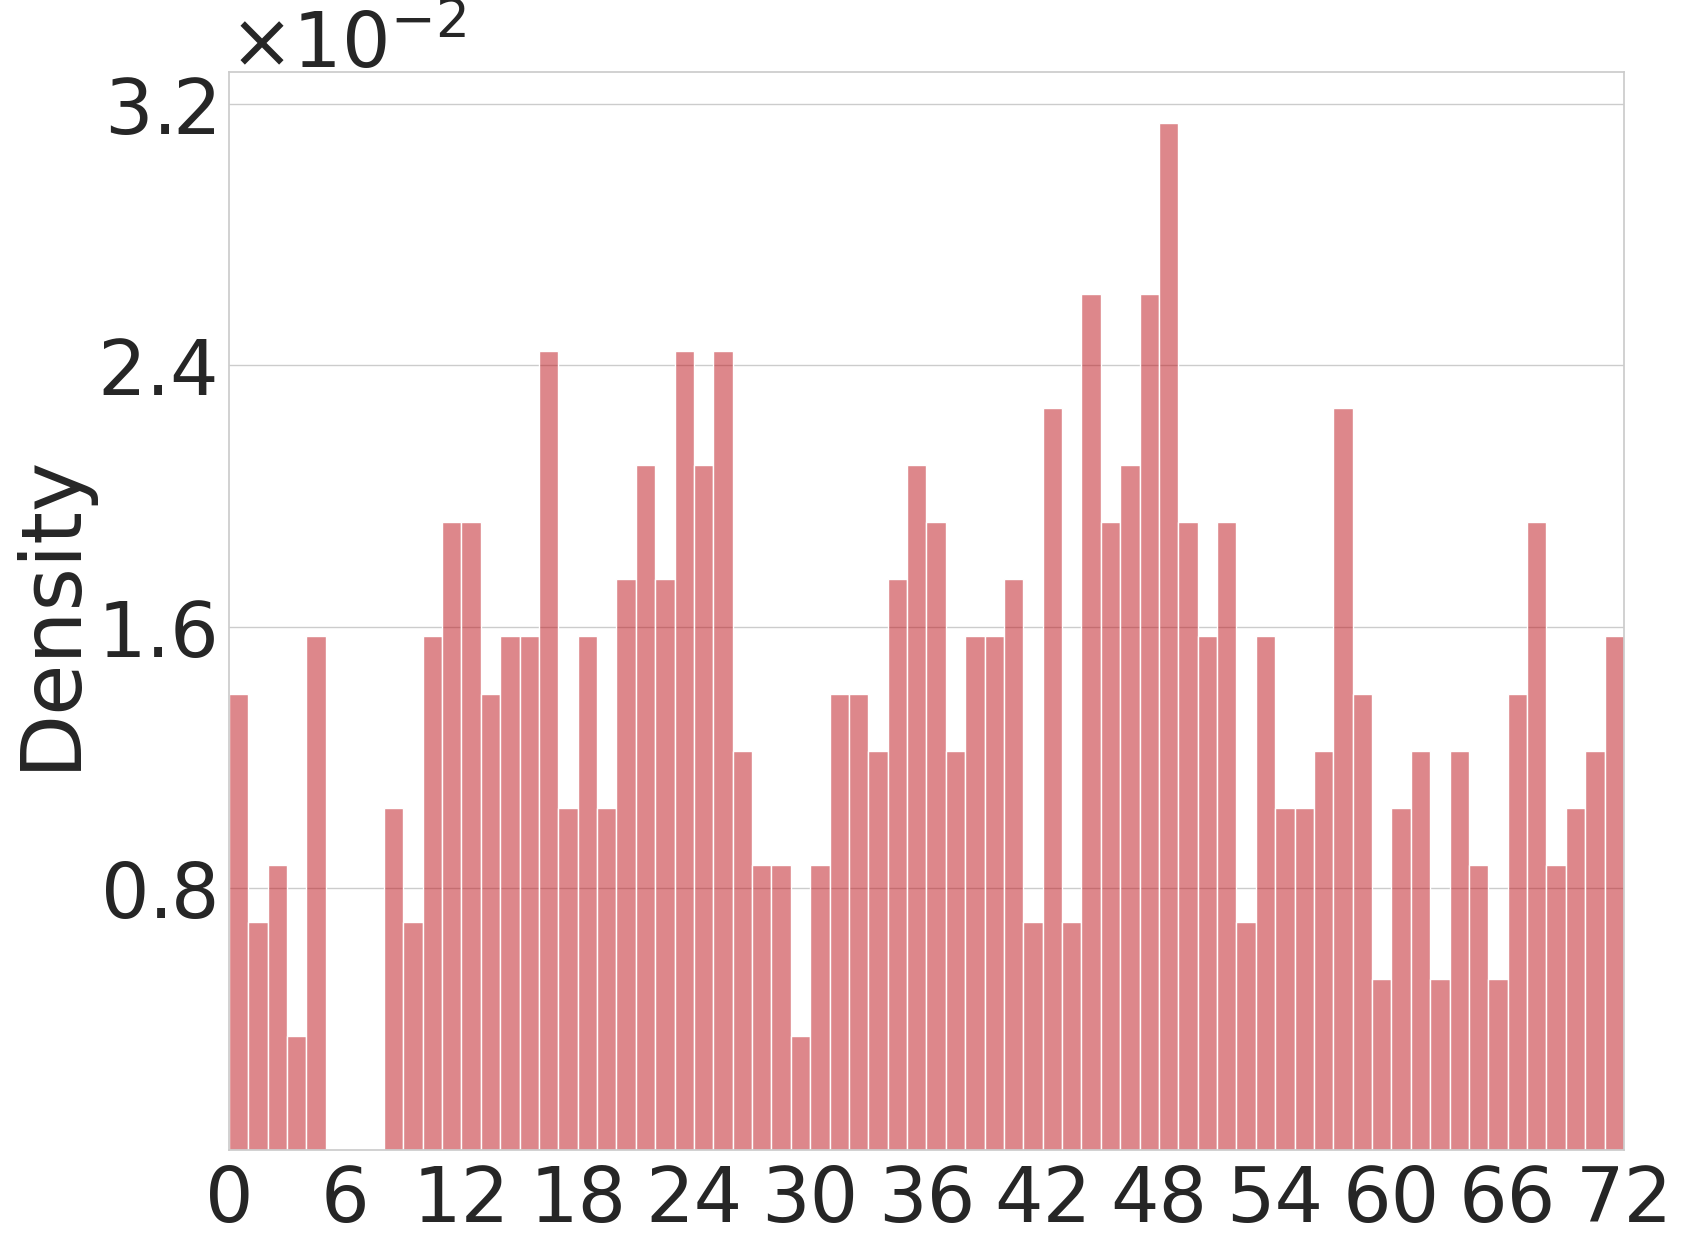

In [103]:
plot_histogram(
    df=df_survival_time.filter(pl.col(SURVIVAL_TIME_ROUND) <= N_HOURS).select(
        SURVIVAL_TIME_ROUND
    ),
    column_name=SURVIVAL_TIME_ROUND,
    x_max=N_HOURS,
    bins=N_HOURS,
    fontsize=60,
    num_xticks=N_HOURS // 6,
    num_yticks=5,
    save_path=PLOT_PATH.joinpath(SURVIVAL_TIME_ROUND + f".png"),
)

In [104]:
CUM_SUM_FRAC = "cum_sum_frac"
df_agg_survival_time = (
    df_survival_time[SURVIVAL_TIME_ROUND]
    .value_counts(sort=True)
    .with_columns(pl.col("count").cum_sum().alias(CUM_SUM_FRAC) / pl.col("count").sum())
)
df_agg_survival_time.head(5)

survival_time_hours,count,cum_sum_frac
f64,u32,f64
48.0,18,0.001743
164.0,16,0.003293
47.0,15,0.004745
44.0,15,0.006198
23.0,14,0.007554


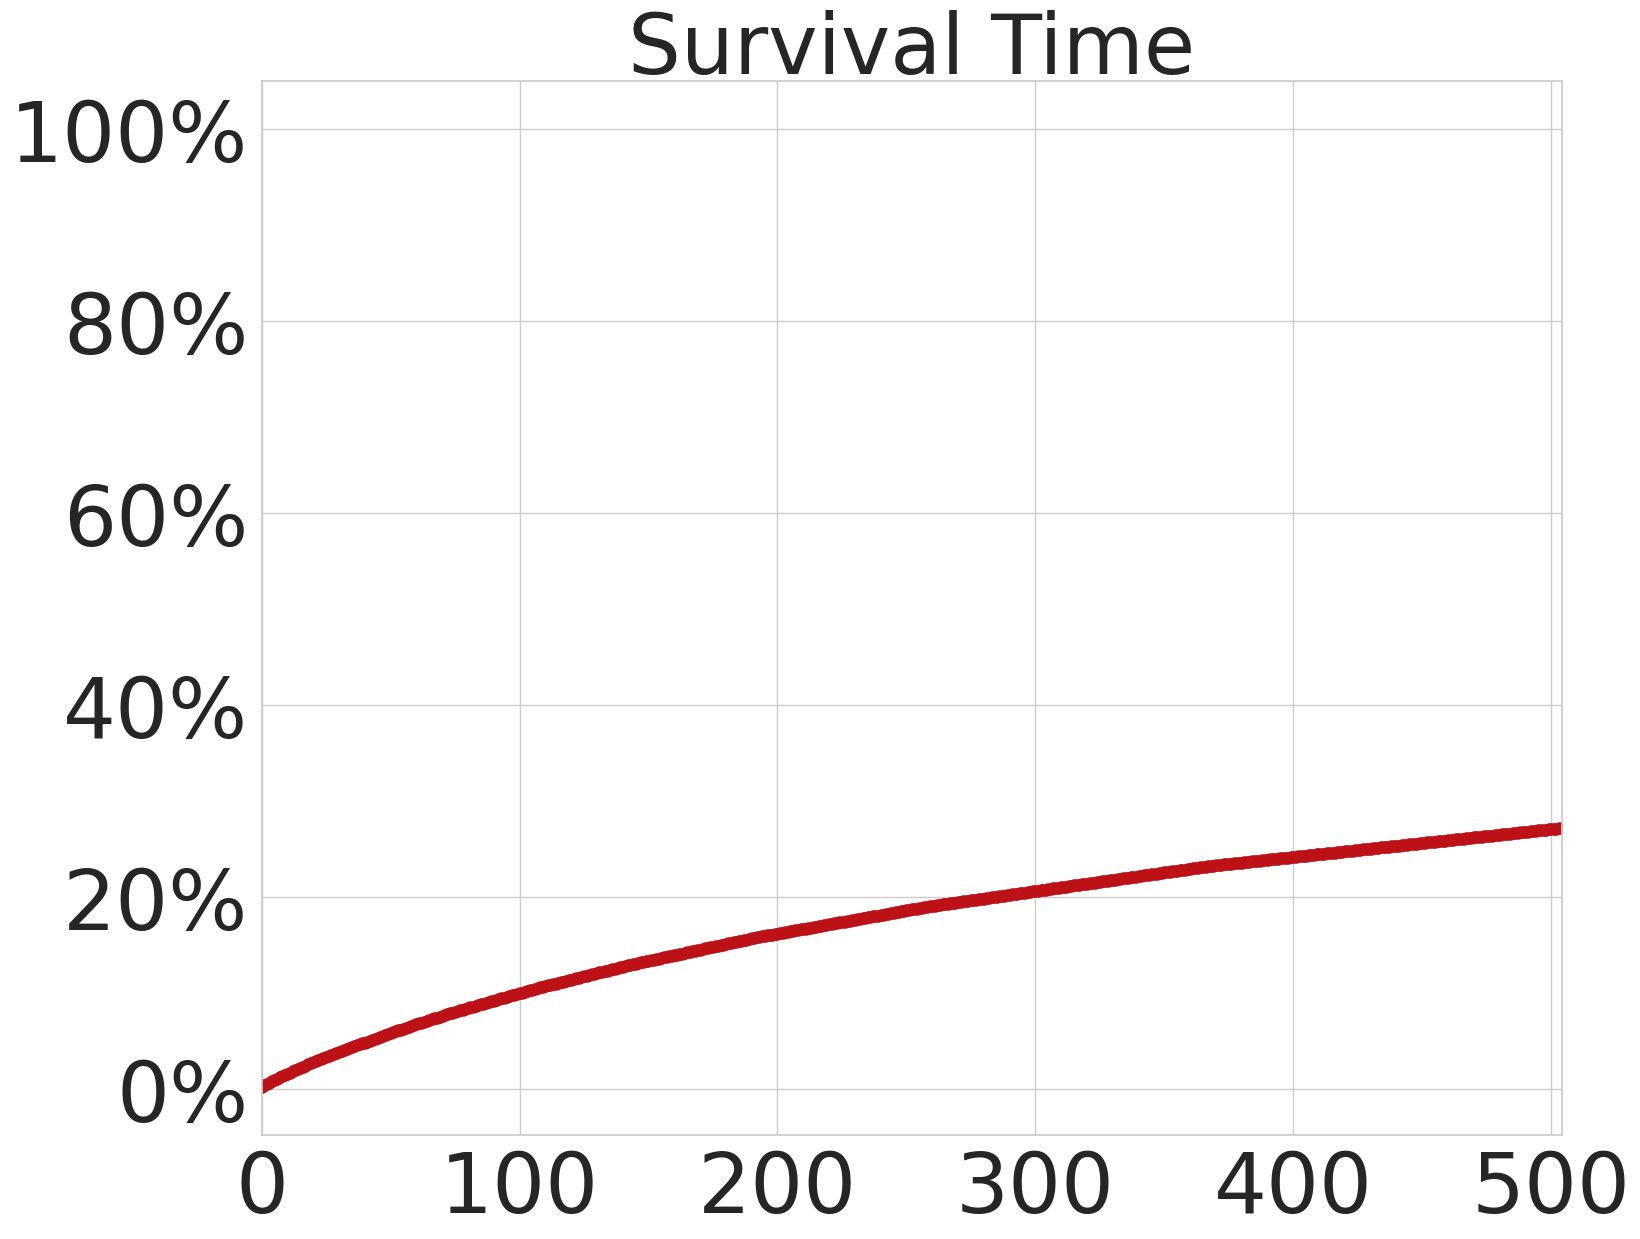

In [114]:
X_HOURS = 504
create_plot(
    df_agg_survival_time[CUM_SUM_FRAC],
    fontsize=60,
    marker="o",
    y_as_percentage=True,
    num_xticks=6,
    x_max=X_HOURS,
    color=EB_COLOR,
    linewidth=4,
    markersize=8,
    linestyle="-",
    title="Survival Time",
    save_path=PLOT_PATH.joinpath(f"survival_time_{X_HOURS}.png"),
)

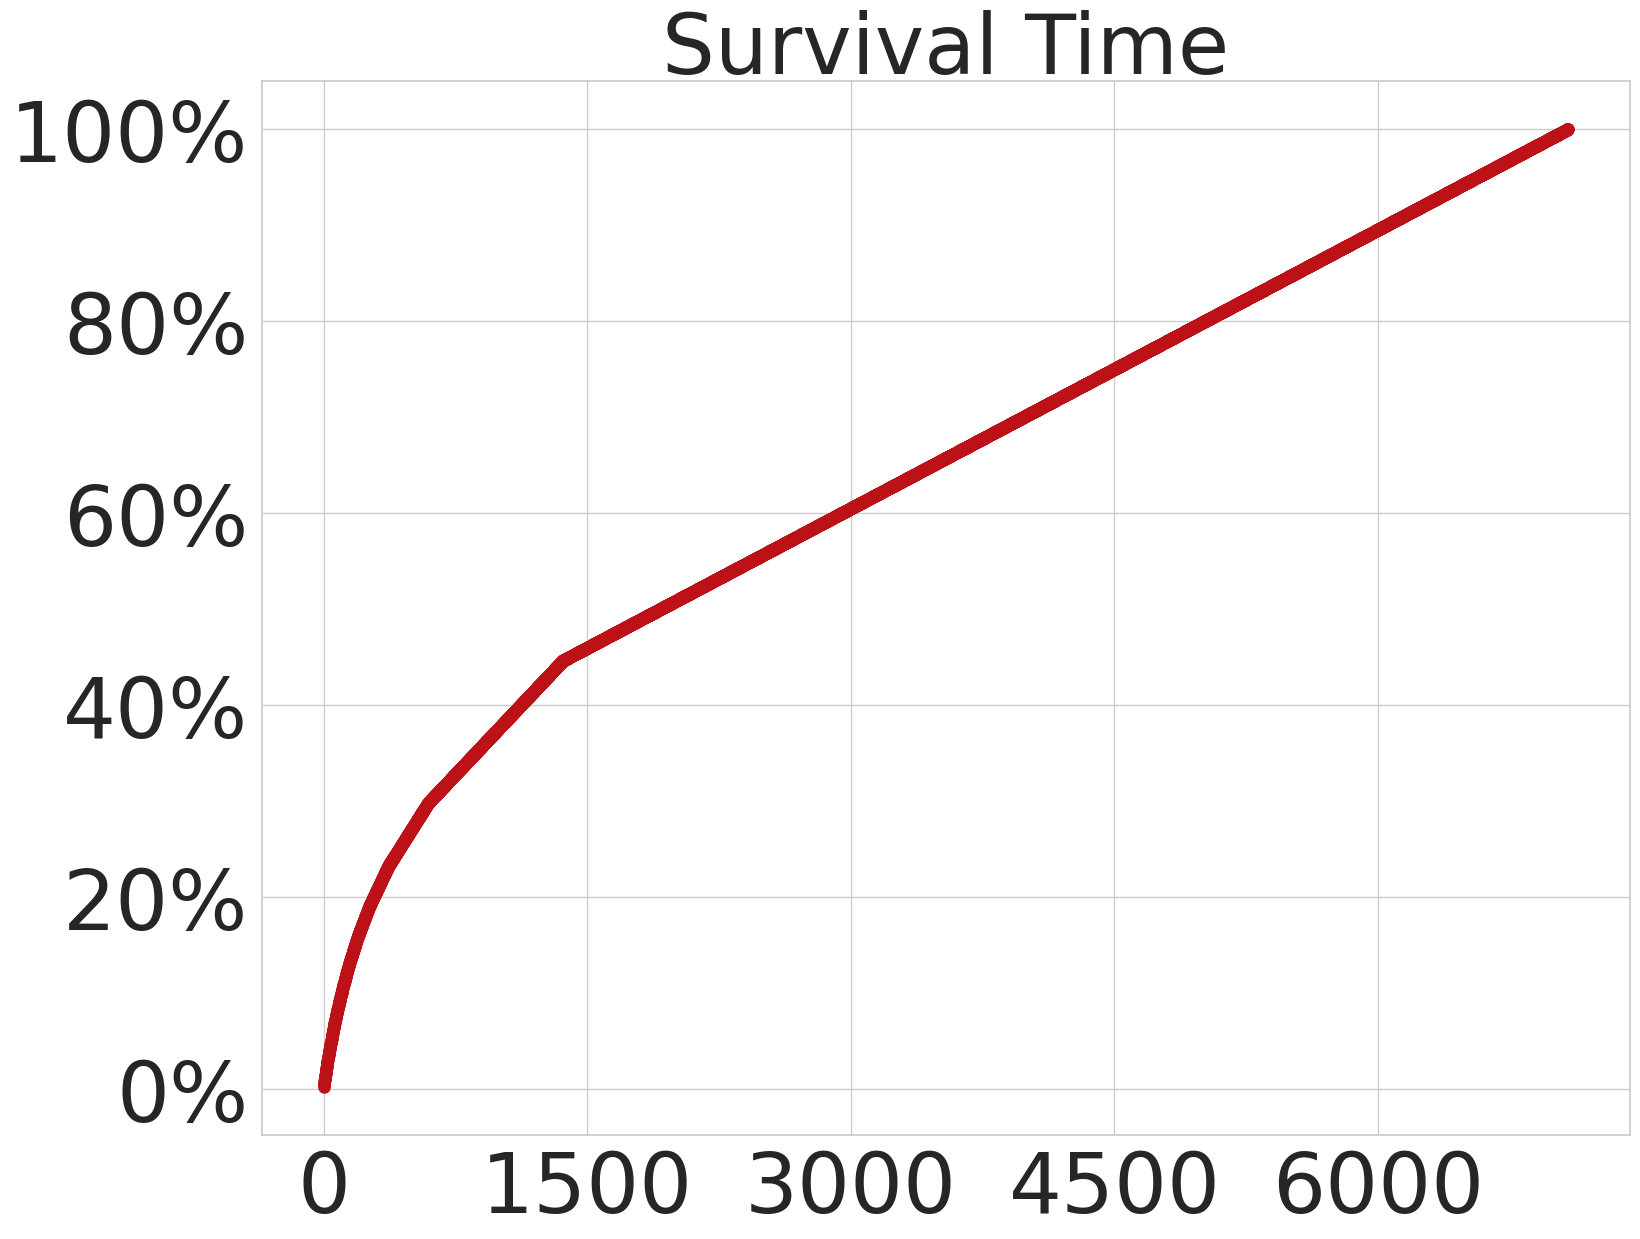

In [107]:
create_plot(
    df_agg_survival_time[CUM_SUM_FRAC],
    fontsize=60,
    marker="o",
    y_as_percentage=True,
    num_xticks=6,
    color=EB_COLOR,
    linewidth=4,
    markersize=8,
    linestyle="-",
    title="Survival Time",
    save_path=PLOT_PATH.joinpath(f"survival_time_full.png"),
)

# DONE 🚀